## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import cmp_to_key
from sklearn.decomposition import PCA
from sortedcontainers import SortedDict
from operator import itemgetter, attrgetter
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

## Printing

In [2]:
def PrintSortDict(sd):
    for k in sd.keys():
        print(f"X:{k}; Y:{sd[k]}")

def PrintKeys(sd):
    for k in sd.keys():
        print(f"{k}; ")

def PrintScope(sd):
    for k in sd.keys():
        print(f"Vizinhos de {k.id}: ")
        for kk in sd[k].keys():
            print(f"{kk.id}: {sd[k][kk]}")

In [3]:
def PrintHulls(ph_one, ph_two):
    fig, ax = plt.subplots()
    x = []
    y = []
    for key in ph_one:
        x.append(key.x)
        y.append(key.y)
    x.append(x[0])
    y.append(y[0])
    ax.plot(x, y, marker='o', color='b')
    x = []
    y = []
    for key in ph_two:
        x.append(key.x)
        y.append(key.y)
    x.append(x[0])
    y.append(y[0])
    ax.plot(x, y, marker='o', color='r')
    
def PrintHullsAndSeparator(ph_one,ph_two,sep):
    fig, ax = plt.subplots()
    x = []
    y = []
    for key in ph_one:
        x.append(key.x)
        y.append(key.y)
    x.append(x[0])
    y.append(y[0])
    ax.plot(x, y, marker='o', color='b')
    x = []
    y = []
    for key in ph_two:
        x.append(key.x)
        y.append(key.y)
    x.append(x[0])
    y.append(y[0])
    ax.plot(x, y, marker='o', color='r')
    x_limits = ax.get_xlim()
    y_limits = ax.get_ylim()
    ax.set_ylim(y_limits)
    slope, inter = sep
    x = x_limits
    y = []
    y.append(slope*x[0]+inter)
    y.append(slope*x[1]+inter)
    ax.plot(x,y,color='g')

## Classes

In [4]:
class Point:
    id = 1
    def __init__(self,a,b, c = 0, shake=1e-5):
        self.id = Point.id
        Point.id+=1
        shakes = np.random.uniform(-shake, shake, 2)
        self.x = a+shakes[0]
        self.y = b+shakes[1]
        self.classe = c

    def __add__(self, other):
        if isinstance(other, Point):
            return Point(self.x+other.x, self.y+other.y)
        elif isinstance(other, np.ndarray):
            return Point(self.x+other[0],self.y+other[1],shake=0)
        else:
            raise TypeError("Unsupported operand type")
        
    def __sub__(self, other):
        if isinstance(other, Point):
            return Point(self.x-other.x, self.y-other.y)
        else:
            raise TypeError("Unsupported operand type")
        
    def __truediv__(self,other):
        return Point(self.x/other,self.y/other)
        
    def __str__(self):
        return str(self.id)+": "+str(self.x)+"   "+str(self.y)
        
    def Shake(self,shake):
        shakes = np.random.uniform(-shake,shake,2)
        self.x+=shakes[0]
        self.y+=shakes[1]
        return self

    def Reset():
        Point.id = 1

In [5]:
class Segment:
    id = 1
    def __init__(self,a: Point, b: Point, enforce_order=True, shake = 0):
        if b.x<a.x and enforce_order:
            temp = a
            a = b
            b = temp
        self.bgn = a.Shake(shake)
        self.end = b.Shake(shake)
        self.slope = (self.end.y-self.bgn.y)/(self.end.x-self.bgn.x)
        self.intercept = self.end.y - (self.slope * self.end.x)
        self.id = Segment.id
        Segment.id+=1
        
    
    def Y_At_X(self,x):
        return self.slope*x+self.intercept


    def Invert(self):
        temp = self.bgn
        self.bgn = self.end
        self.end = temp


    def __str__(self):
        return "Id: "+str(self.id)+"\nBegin: "+str(self.bgn.x)+"   "+str(self.bgn.y)+"\nEnd: "+str(self.end.x)+"   "+str(self.end.y)
    
    def __lt__(self,other):
        if isinstance(other, Segment):
            return self.bgn.x < other.bgn.x
        else:
            raise TypeError("Unsupported operand type")
        
    def Reset():
        Segment.id = 1

## Primitivas

In [6]:
def Clockwise(a: Segment, b: Segment): #returns true if a is clockwise to b
    frst_seg = a.end - a.bgn
    scnd_seg = b.end - b.bgn
    vec_prod = (frst_seg.x*scnd_seg.y)-(frst_seg.y*scnd_seg.x)
    if vec_prod>0:
        return True
    elif vec_prod<0:
        return False
    else:
        print(a)
        print(b)
        raise Exception("Segments are parallel")

In [7]:
def SegmentsIntercept(a: Segment, b: Segment):
    check_one = Clockwise(a,Segment(a.bgn,b.bgn))
    check_two = Clockwise(a,Segment(a.bgn,b.end))
    if check_one==check_two:
        return False
    check_one = Clockwise(b,Segment(b.bgn,a.bgn))
    check_two = Clockwise(b,Segment(b.bgn,a.end))
    if check_one==check_two:
        return False
    return True

## Convex Hull

In [9]:
def is_clockwise(p, q, r):
    prod_vec = ((q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y))
    if prod_vec > 0:
        return 1
    else:
        return -1

def ConvexHullGraham(data):
    stack = []
    points = np.array([Point(p[0],p[1]) for p in data])

    p0 = min(points,key=attrgetter('y','x'))

    min_po = np.where(points == p0)[0][0]

    points[min_po], points[0] = points[0], points[min_po]

    points = sorted(points,key=cmp_to_key(lambda p1,p2: is_clockwise(p0,p1,p2)))

    for p in points:
        while len(stack) > 1 and (is_clockwise(stack[-2],stack[-1],p) == 1):
            stack.pop()
        stack.append(p)
    return stack

## Sweep Line

GetSegments: recebe um conjunto de pontos da envoltória convexa e retorna o conjunto de segmentos da envoltória.

In [10]:
def GetSegments(polar_hull):
    n = len(polar_hull)
    #keys = list(polar_hull.keys())
    #keys = list(range(len(polar_hull)))
    segments_hull = SortedDict()
    count = 0
    #for key in polar_hull.keys():
    for key in polar_hull:
        next_key = polar_hull[(count + 1) % n]
        s = Segment(key,next_key)
        count+=1
        segments_hull[s.bgn.x] = (s,0)
        segments_hull[s.end.x] = (s,1)
    return segments_hull

In [11]:
def SweepLine(segment_hull_one, segments_hull_two):
    segments_set = segment_hull_one.copy()
    
    segments_set.update(segments_hull_two)
    scope = SortedDict()
    for key in segments_set.keys():
        current_segment, end = segments_set[key]
        if not end: #início do segmento
            comparisons = dict()
            for comparable_segment in scope.keys():
                if key==comparable_segment.end.x:
                    '''no op'''
                else:
                    aux = (current_segment.bgn.y>comparable_segment.Y_At_X(key))
                    comparisons[comparable_segment] = aux
                    scope[comparable_segment][current_segment] = not aux
            scope[current_segment] = comparisons
            
        else:                          #fim do segmento
            if current_segment in scope:
                comparisons = scope[current_segment]
                del scope[current_segment]
                for comparable_segment in scope.keys():
                    if key==comparable_segment.bgn.x:
                        '''no op'''
                    else:
                        if comparable_segment in comparisons:
                            aux = (current_segment.end.y>comparable_segment.Y_At_X(key))
                            if comparisons[comparable_segment] != aux:
                                return True
    return False

## Classification

Distance: computa a distância euclidiana entre 2 pontos.

SegFromPointToSeg: primeiro computa a reta perpendicular ao segmento **s** que passa por **p**, calcula o ponto de interseção entre essa reta e o segmento, por fim retorna esse ponto de interseção e a distância entre **p** e ele. Essa também é a distância entre **p** e **s**.
Se o ponto de interseção estiver fora do segmento, retorna None no lugar do ponto de interseção e infinito no lugar da distância.


SegFromPointToSegDev: Análoga a função anterior, mas desenha os objetos que ela calcula.

In [12]:
def Distance(a: Point, b: Point):
    return np.sqrt((a.x-b.x)**2+(a.y-b.y)**2)

def SegFromPointToSeg(p:Point, s:Segment):
    ps_slope = -1/s.slope
    ps_inter = p.y-ps_slope*p.x
    x = (ps_inter-s.intercept)/(s.slope-ps_slope)
    y = ps_slope*x+ps_inter
    if x<s.bgn.x or x>s.end.x:
        return np.inf, None
    intermed_point = Point(x,y)
    d = Distance(p,intermed_point)
    return d, intermed_point

def SegFromPointToSegDev(p:Point, s:Segment):
    ps_slope = -1/s.slope
    ps_inter = p.y-ps_slope*p.x
    xp = np.array([-8.1, 8.1])
    yp = xp*ps_slope+ps_inter
    plt.plot(p.x,p.y,marker='o', color='y')
    plt.plot(xp,yp,color='r')
    xperp = np.array([s.bgn.x,s.end.x])
    yperp = np.array([s.bgn.y,s.end.y])
    plt.plot(xperp,yperp,color='b')
    x = (ps_inter-s.intercept)/(s.slope-ps_slope)
    y = ps_slope*x+ps_inter
    if x<s.bgn.x or x>s.end.x:
        return np.inf, None
    intermed_point = Point(x,y)
    plt.plot(x,y,marker='o',color='g')
    d = Distance(p,intermed_point)
    return d, intermed_point


Classificator: recebe duas envoltórias convexas, primeiro computa o par de pontos mais próximo entre as 2 envoltórias, depois compara a a distância do ponto da escolhido da primeira envoltória aos 2 segmentos que tocam o ponto escolhido da segunda envoltória, compara a distância do ponto escolhido da segunda envoltória aos 2 segmentos que tocam o ponto escolhido da primeira envoltória. A menor dessas distâncias é a distância entre as 2 envoltórias. Por fim essa função calcula a reta perpendicular que passa pelo ponto médio da menor reta entre as duas envoltória e retorna os coeficientes dessa reta.

In [13]:
def Classificator(ph_one, ph_two):
    min = np.inf
    for key in ph_one:
        for kkey in ph_two:
            d = Distance(key,kkey)
            if d<min:
                min = d
                closest_pair = (key,kkey)
    hulls = (ph_one,ph_two)
    distances = SortedDict()
    distances[d] = closest_pair
    for i in range(2):
        p = closest_pair[i]
        next_point_index = (hulls[i].index(p)+1)%len(hulls[i])
        next_point = hulls[i][next_point_index]
        next_seg = Segment(p,next_point)
        d, intermed_point = SegFromPointToSeg(closest_pair[(i+1)%2],next_seg)
        if d!=np.inf:
            distances[d] = (intermed_point,closest_pair[(i+1)%2])

        prev_point_index = (hulls[i].index(p)-1)%len(hulls[i])
        prev_point = hulls[i][prev_point_index]
        prev_seg = Segment(p,prev_point)
        d, intermed_point = SegFromPointToSeg(closest_pair[(i+1)%2],prev_seg)
        if d!=np.inf:
            distances[d] = (intermed_point,closest_pair[(i+1)%2])

    first_key = distances.peekitem(0)[0]
    ends = distances[first_key]
    s = Segment(ends[0],ends[1])
    med_p = Point(0.5*(s.bgn.x+s.end.x),0.5*(s.bgn.y+s.end.y))
    slope = -1/s.slope
    intercept = med_p.y-slope*med_p.x

    return slope, intercept

    
    


## Data Load and Modelling

In [14]:
#Dictionary where all the dabases will be stocked to execute in the pipeline
all_database = dict()

### Rice Classification (Non Separable)

In [15]:
rice = pd.read_csv("./dataSets/rice+cammeo+and+osmancik/Rice_Cammeo_Osmancik.csv",sep=',')
rice.iloc[:,-1].value_counts()

Cammeo
Osmancik    2180
Cammeo      1629
Name: count, dtype: int64

In [16]:
pca = PCA(2)
data = pca.fit_transform(rice.iloc[:,:-1])
label_orig = rice.iloc[:,-1]
label = (label_orig != 'Cammeo').astype(int)
label.value_counts()
all_database['Rice'] = [data,label]

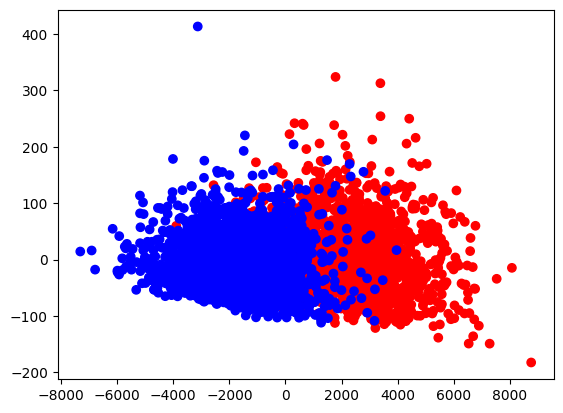

In [17]:
color = ['red' if l == 0 else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1],color=color)
plt.show()

### Iris Classification (Separable)

In [18]:
iris_data = pd.read_csv("./dataSets/Iris.csv")
iris_data.iloc[:,-1].value_counts()

Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

In [19]:
pca = PCA(2)
data = pca.fit_transform(iris_data.iloc[:,:-1])
label_orig = iris_data.iloc[:,-1]
label = (label_orig != 'Iris-setosa').astype(int)
label.value_counts()
all_database['Iris'] = [data,label]

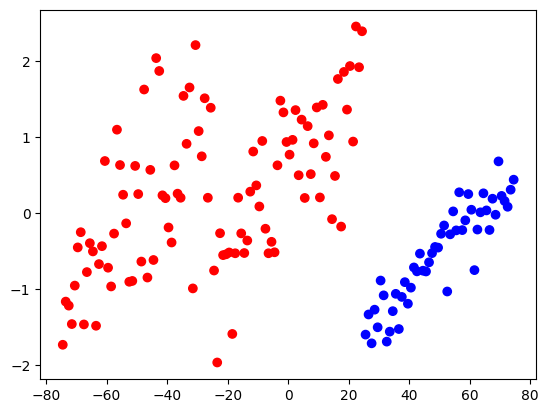

In [20]:
color = ['red' if l == 1 else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1],color=color)
plt.show()

### Spam classification (Non Separable)

In [21]:
#Source = https://archive.ics.uci.edu/dataset/94/spambase
spambase_data = pd.read_csv("./dataSets/spambase/spambase.data",header=None)
pca = PCA(2)
data = pca.fit_transform(spambase_data.iloc[:,:-1])
label = spambase_data.iloc[:,-1]
label = (label == 1).astype(int)

In [22]:
#Duas Classes
all_database['Spam'] = [data,label]
label.value_counts()

57
0    2788
1    1813
Name: count, dtype: int64

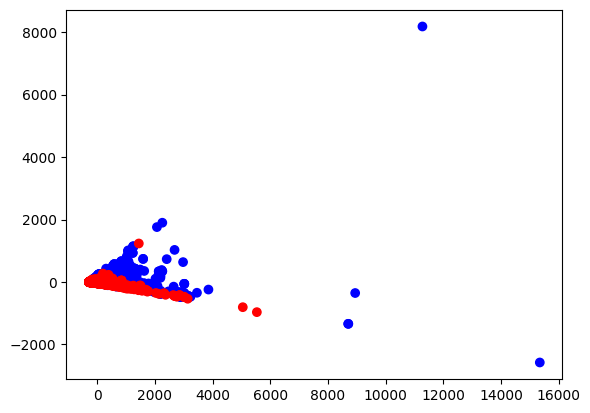

In [23]:
color = ['red' if l == 0 else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1],color=color)
plt.show()

### Haberman (Non Separable)

In [24]:
#Source = https://archive.ics.uci.edu/dataset/43/haberman+s+survival
haberman = pd.read_csv("./dataSets/haberman+s+survival/haberman.data",header=None)
pca = PCA(2)
data = pca.fit_transform(haberman.iloc[:,:-1])
label = haberman.iloc[:,-1]
label = (label == 1).astype(int)

In [25]:
#Duas classes
all_database['Haberman'] = [data,label]
label.value_counts()

3
1    225
0     81
Name: count, dtype: int64

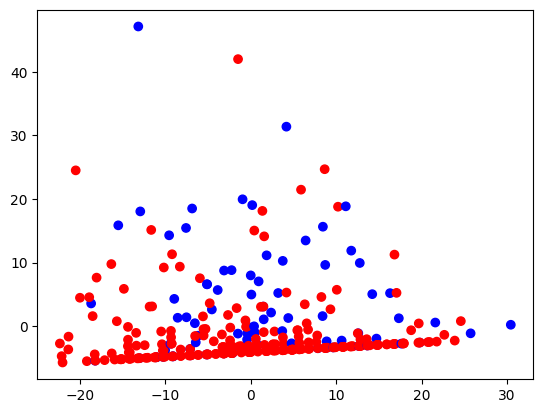

In [26]:
color = ['red' if l == 1 else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1], color=color)
plt.show()

### Pen Writing Recognition (Non Separable)

In [27]:
#Source = https://archive.ics.uci.edu/dataset/81/pen+based+recognition+of+handwritten+digits
pen_recog_training = pd.read_csv("./dataSets/pen+based+recognition+of+handwritten+digits/pendigits.tra",header=None)
pen_recog_test = pd.read_csv("./dataSets/pen+based+recognition+of+handwritten+digits/pendigits.tes",header=None)
pen_recog = pd.concat([pen_recog_training,pen_recog_test],axis=0)

In [28]:
pca = PCA(2)
data = pca.fit_transform(pen_recog.iloc[:,:-1])
label_orig = pen_recog.iloc[:,-1]

In [29]:
#Dez classes
label_orig.value_counts()

16
2    1144
4    1144
1    1143
0    1143
7    1142
6    1056
8    1055
5    1055
9    1055
3    1055
Name: count, dtype: int64

In [30]:
#Convertida para duas (Se o dígito escrito for menor que 5)
label = (label_orig < 5).astype(int)
all_database['PenWriting'] = [data,label]
label.value_counts()

16
1    5629
0    5363
Name: count, dtype: int64

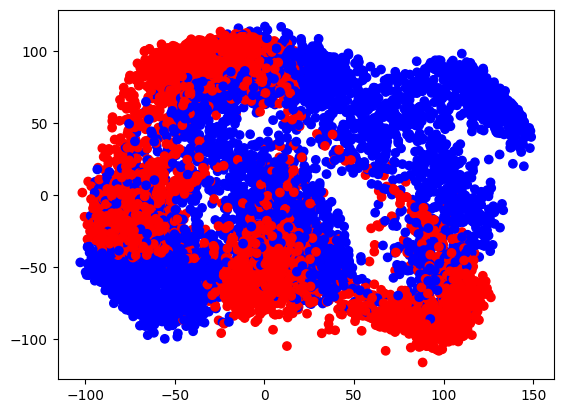

In [31]:
color = ['red' if l == 1 else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1], color=color)
plt.show()

### Magic (Non Separable)

In [32]:
#Source = https://archive.ics.uci.edu/dataset/110/yeast
#Tive que fazer algumas modificações no arquivo direto no excel para mudar a delimitação do arquivo csv e alinhar algumas linhas que não estavam alinhadas com as colunas
tic_tac_toe = pd.read_csv("./dataSets/tic-tac-toe.prepared.txt",sep=",")
pca = PCA(2)
data = pca.fit_transform(tic_tac_toe.iloc[:,:-1])
label = tic_tac_toe.iloc[:,-1]
label = (label == 'positive').astype(int)

In [33]:
all_database['TicTacToe'] = [data,label]
label.value_counts()

Class
1    626
0    332
Name: count, dtype: int64

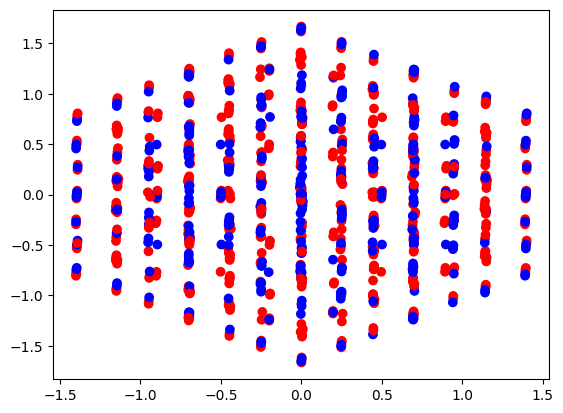

In [34]:
color = ['red' if l == 1 else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1],color=color)
plt.show()

### Balance (Non Separable)

In [35]:
#Source = https://sci2s.ugr.es/keel/dataset.php?cod=54
balance = pd.read_csv("./dataSets/balance.dat.csv",header=None)
pca = PCA(2)
data = pca.fit_transform(balance.iloc[:,:-1])
label_orig = balance.iloc[:,-1]

In [36]:
label_orig.value_counts()

4
 R    288
 L    288
 B     49
Name: count, dtype: int64

In [37]:
label = (label_orig != ' R').astype(int)
label.value_counts()

4
1    337
0    288
Name: count, dtype: int64

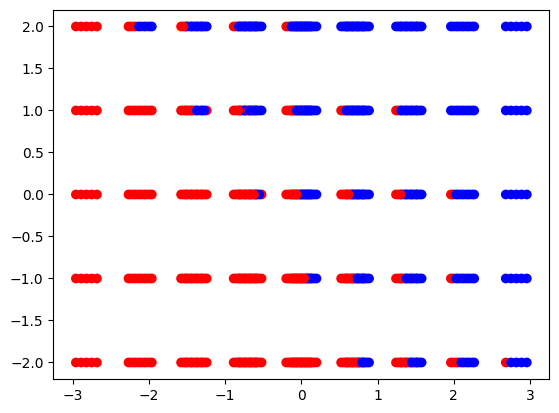

In [38]:
color = ['red' if l == 1 else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1],color=color)
plt.show()

### Hayes Roth (Non Separable)

In [39]:
#Source = https://sci2s.ugr.es/keel/dataset.php?cod=186
hayes_r = pd.read_csv("./dataSets/hayes-roth.dat",header=None,sep=",")
#hayes_r = hayes_r[hayes_r.iloc[:,-1] != 2]
pca = PCA(2)
data = pca.fit_transform(hayes_r.iloc[:,:-1])
label = hayes_r.iloc[:,-1]
label = (label == 3).astype(int)

In [40]:
label.value_counts()
all_database['Hayes Roth'] = [data,label]

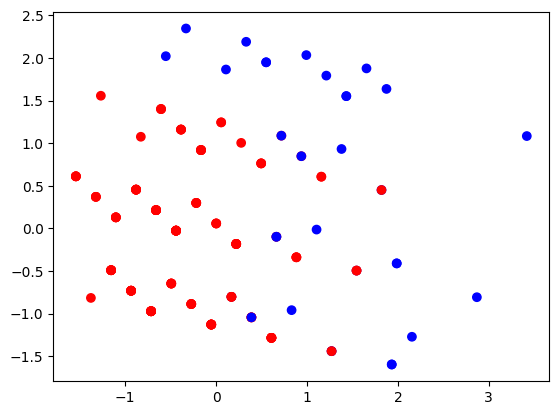

In [41]:
color = ['red' if l == 0 else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1],color=color)
plt.show()

### Titanic Survival (Non Separable)

In [42]:
#Source = https://sci2s.ugr.es/keel/dataset.php?cod=189
titanic = pd.read_csv("./dataSets/titanic.dat",header=None,sep=",")
pca = PCA(2)
data = pca.fit_transform(titanic.iloc[:,:-1])
label = titanic.iloc[:,-1]
label = (label==1).astype(int)

In [43]:
all_database['Titanic'] = [data,label]
label.value_counts()

3
0    1490
1     711
Name: count, dtype: int64

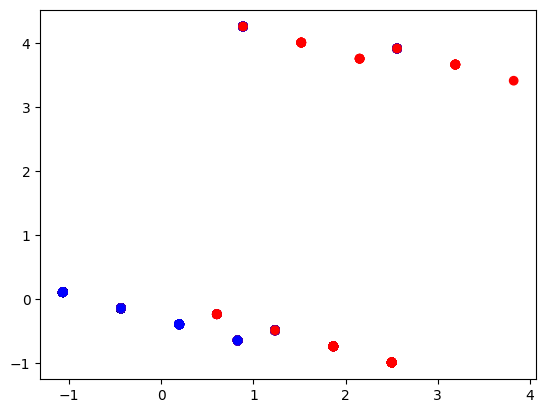

In [44]:
color = ['red' if l == 1 else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1], color=color)
plt.show()

### Wine classification (Separable)

In [45]:
wine = pd.read_csv("./dataSets/wine.prepared.txt",sep=",")

In [46]:
# Retirada a classe 2 para que fique linearmente separável
wine = wine[wine['Class'] != 2]
pca = PCA(2)
data = pca.fit_transform(wine.iloc[:,:-1])
label = wine.iloc[:,-1].reset_index(drop=True)
label = (label == max(label)).astype(int)
all_database['Wine'] = [data,label]

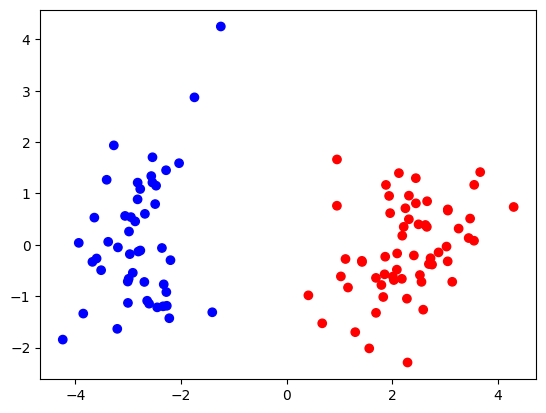

In [47]:
color = ['red' if l == 0 else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1], color=color)
plt.show()

## Model Definition

In [48]:
class Geometric_Classificator:
    def __init__(self):
        self.hulls = []
        return

    def fit(self, x_train, y_train):
        #Buid the convex hull to each label
        for label in set(y_train):
            set_coord = x_train[y_train == label]
            
            #Receives data as numpy array
            self.hulls.append(ConvexHullGraham(set_coord))

        s1 = GetSegments(self.hulls[0])
        s2 = GetSegments(self.hulls[1])
        
        #Apply SweepLine in both Hulls to check for intersections
        if(not SweepLine(s1,s2)):
            #If there's NO intersections between the Hulls's Segments
            print("\tData is linear separable\n")
        else:
            print("\tData is not linear separable\n")
            return False
        
        self.separator = Classificator(self.hulls[0], self.hulls[1])
        return True
    
    def predict(self, X_test):
        return (self.separator[0]*X_test[:,0] + self.separator[1] < X_test[:,1]).astype(int)

In [49]:
def pipeline(all_data):
    models = dict()
    for data_name,[data,label] in all_data.items():
        print(f"------------------------{data_name} Database ----------------------------\n")
        X_train, X_test, y_train, y_test = train_test_split(data,label,test_size=0.2,random_state=42)
        gc = Geometric_Classificator()
        is_separable = gc.fit(X_train,y_train)

        if(is_separable):
            PrintHullsAndSeparator(gc.hulls[0], gc.hulls[1],gc.separator)
            plt.title(f"Eq. da Reta - y = {np.round(gc.separator[0],2)}x + {np.round(gc.separator[1],2)}")
            color = ['blue' if l == 0 else 'red' for l in label]
            plt.scatter(data[:,0],data[:,1],color=color)
            plt.show()

            y_pred = gc.predict(X_test)
            print("Precisão = ", precision_score(y_true=y_test,y_pred=y_pred))
            print("Revocação = ", recall_score(y_true=y_test,y_pred=y_pred))
            print("F1-Score = ", f1_score(y_true=y_test,y_pred=y_pred))

        models[data_name] = gc
    return models

In [50]:
all_database.keys()

dict_keys(['Rice', 'Iris', 'Spam', 'Haberman', 'PenWriting', 'TicTacToe', 'Hayes Roth', 'Titanic', 'Wine'])

------------------------Rice Database ----------------------------

	Data is not linear separable

------------------------Iris Database ----------------------------

	Data is linear separable



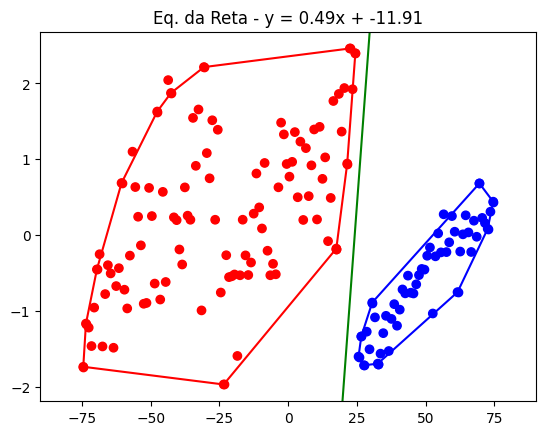

Precisão =  1.0
Revocação =  1.0
F1-Score =  1.0
------------------------Spam Database ----------------------------

	Data is not linear separable

------------------------Haberman Database ----------------------------

	Data is linear separable



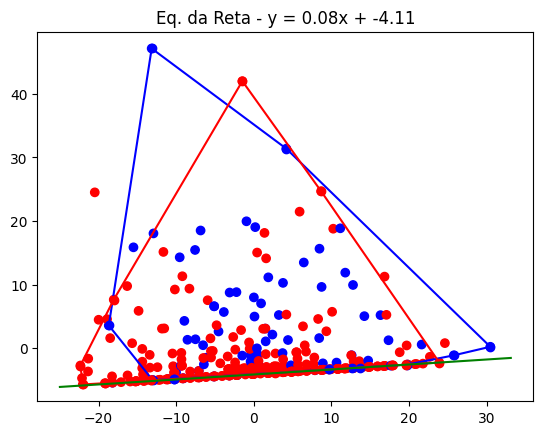

Precisão =  0.7096774193548387
Revocação =  1.0
F1-Score =  0.8301886792452831
------------------------PenWriting Database ----------------------------

	Data is not linear separable

------------------------TicTacToe Database ----------------------------

	Data is not linear separable

------------------------Hayes Roth Database ----------------------------

	Data is linear separable



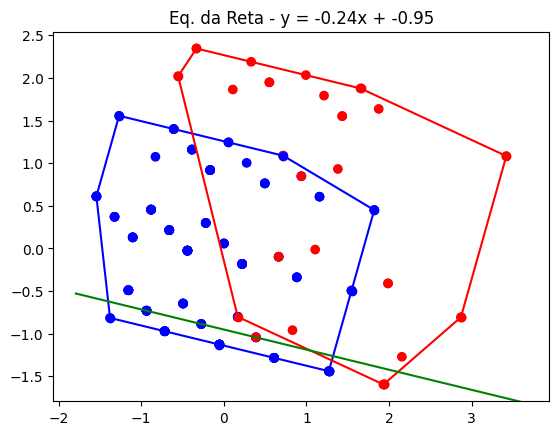

Precisão =  0.19230769230769232
Revocação =  0.8333333333333334
F1-Score =  0.3125
------------------------Titanic Database ----------------------------

	Data is linear separable



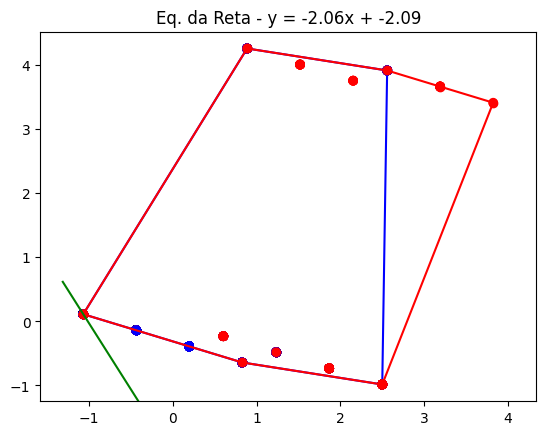

Precisão =  0.36281179138321995
Revocação =  1.0
F1-Score =  0.5324459234608985
------------------------Wine Database ----------------------------

	Data is linear separable



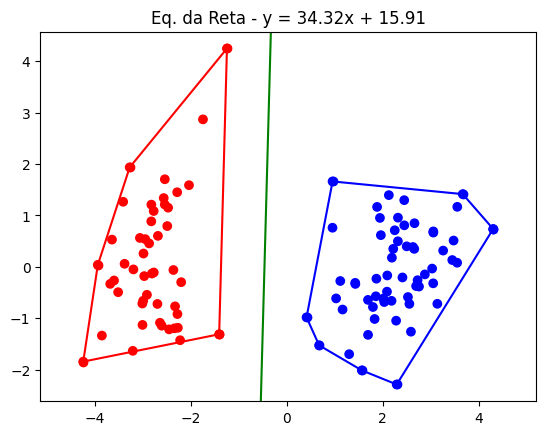

Precisão =  1.0
Revocação =  1.0
F1-Score =  1.0


In [51]:
models = pipeline(all_database)

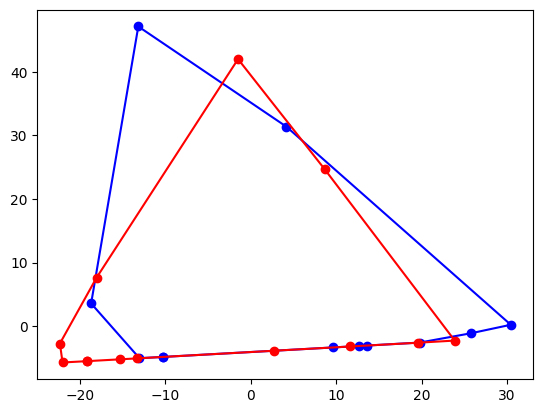

In [52]:
PrintHulls(models['Haberman'].hulls[0],models['Haberman'].hulls[1])

For some reason the SweepLine in the test case with the Haberman Database, does not identify the colision in the segments of each Hull. It's all buggy lol